In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score, recall_score
from tqdm import tqdm

import sys
sys.path.append("../scripts")

import data
import experiments
import utils


%load_ext autoreload
%autoreload 2

In [2]:
methods_color = {
    "LGBMClassifier" : "#ffd92f",
    "FairGBMClassifier" : "#fc8d62",
    "FairGBMClassifier_eod" : "#fc8d62",
    "MinMaxFair" : "#a6d854",
    "MinMaxFair_tpr" : "#a6d854",
    "M2FGB_grad" : "#8da0cb",
    "M2FGB_grad_tpr" : "#8da0cb",
    "M2FGB_grad_pr" : "#8da0cb",
    "MinimaxPareto" : "pink"
}

In [68]:
dataset = "adult"
fold = 0
n_jobs = 6
seed = 42
X_train, A_train, Y_train, X_val, A_val, Y_val, X_test, A_test, Y_test =  data.get_fold(dataset, fold, 10, 8, seed)

{'Male_2': 0, 'Male_4': 1, 'Female_1': 2, 'Female_2': 3, 'Female_3': 4, 'Male_3': 5, 'Male_1': 6, 'Female_4': 7}


## some helper functions

In [4]:
def plot_perf_lines(df_models, fair_metric = "min_acc"):
    fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (18, 5))
    for model in df_models["model"].unique():
        df_model = df_models[df_models["model"] == model]
        
        for i, metric in enumerate(["recall", "bal_acc", fair_metric, "score"]):
            axs[i].plot(df_model["alpha"], df_model[metric], label = model, color = methods_color[model], lw = 2)
            axs[i].set_title(metric)
            axs[i].set_xlabel("alpha")
            axs[i].legend()
    plt.show()

In [4]:
def eval_model_list(model_list, X, Y, A, threshold_list = None):
    results = []
    for m, model in enumerate(model_list):
        y_score = model.predict_proba(X)[:, 1]
        if threshold_list is None:
            thresh = 0.5
        else:
            thresh = threshold_list[m]
            
        y_pred = y_score > thresh
        roc = roc_auc_score(Y, y_score)
        bal_acc = balanced_accuracy_score(Y, y_pred)
        acc = accuracy_score(Y, y_pred)
        rec = recall_score(Y, y_pred)
        min_tpr = 1 - utils.min_true_positive_rate(Y, y_pred, A)
        min_pr = 1 - utils.min_positive_rate(Y, y_pred, A)
        min_bal_acc = 1 - utils.min_balanced_accuracy(Y, y_pred, A)
        min_acc = 1 - utils.min_accuracy(Y, y_pred, A)

        results.append({
            "model" : m,
            "roc" : roc,
            "bal_acc" : bal_acc,
            "acc" : acc,
            "rec" : rec,
            "min_tpr" : min_tpr,
            "min_pr" : min_pr,
            "min_bal_acc" : min_bal_acc,
            "min_acc" : min_acc
        })

    return pd.DataFrame(results)

In [ ]:
def select_model_alpha(model, results_val, results_test, fair_metric):
    alpha_list = [i/10 for i in range(11)]
    results = []

    assert fair_metric in ["min_acc", "min_bal_acc", "min_tpr"]

    for alpha in alpha_list:
        # get best model in validation
        score = results_val["bal_acc"] * alpha + results_val[fair_metric] * (1 - alpha)
        best_model = results_val.iloc[score.idxmax()].model.astype(int)

    
        # get score in test
        r = results_test.iloc[best_model]
        score = r["bal_acc"] * alpha + r[fair_metric] * (1 - alpha)

        results.append({
            "model" : model,
            "alpha" : alpha,
            "bal_acc" : r["bal_acc"],
            "recall" : r["rec"],
            fair_metric : r[fair_metric],
            "score" : score
        })

    return pd.DataFrame(results)


def select_model_alpha_fairgbm(model, results_val, results_test, fair_metric, n_trials = 1000
):
    alpha_list = [i/10 for i in range(11)]
    results = []
    for alpha in alpha_list:
        for trial_i in range(n_trials):
            # random sample some models
            r = results_val.sample(20)
            # get best model in validation
            score = r["bal_acc"] * alpha + r[fair_metric] * (1 - alpha)
            best_model = r.loc[score.idxmax(), :].model.astype(int)
            # get score in test
            r = results_test.iloc[best_model]
            score = r["bal_acc"] * alpha + r[fair_metric] * (1 - alpha)

            results.append({
                "model" : model,
                "alpha" : alpha,
                "trial_i" : trial_i,
                "recall" : r["rec"],
                "bal_acc" : r["bal_acc"],
                fair_metric : r[fair_metric],
                "score" : score
            })

    results = pd.DataFrame(results)
    results = results.groupby(["model", "alpha"]).mean().reset_index()
    return results

## 100 random models, similar to prev experiments

In [5]:
def exp_v1(model, n_trials = 100):
    model_list = []
    param_space = experiments.get_param_spaces(model)
    param_list = experiments.get_param_list(param_space, n_trials)
    model_class = experiments.get_model(model, random_state=seed)
    threshold_list = []
    for params in tqdm(param_list):
        model_ = model_class(**params)
        model_.fit(X_train, Y_train, A_train)
        model_list.append(model_)
        # get the best threshold for each model
        y_score = model_.predict_proba(X_train)[:, 1]
        threshold_list.append(utils.get_best_threshold(Y_train, y_score))
    
    results_train = eval_model_list(
        model_list,
        X_train,
        Y_train,
        A_train,
        threshold_list
    )

    results_val = eval_model_list(
        model_list,
        X_val,
        Y_val,
        A_val,
        threshold_list
    )

    results_test = eval_model_list(
        model_list,
        X_test,
        Y_test,
        A_test,
        threshold_list
    )

    return {
        "model_list" : model_list,
        "results_train" : results_train,
        "results_val" : results_val,
        "results_test" : results_test
    }


In [20]:
results = {}
for model in ["LGBMClassifier", "M2FGB_grad"]:#, "M2FGB_grad_tpr"]:
    results[model] = exp_v1(model, 100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


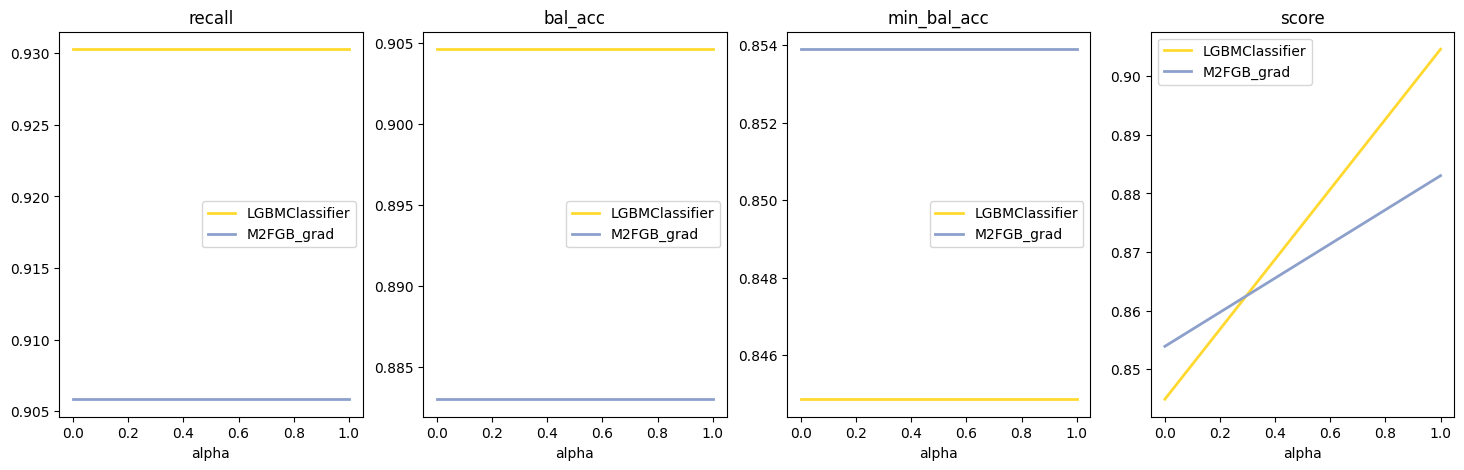

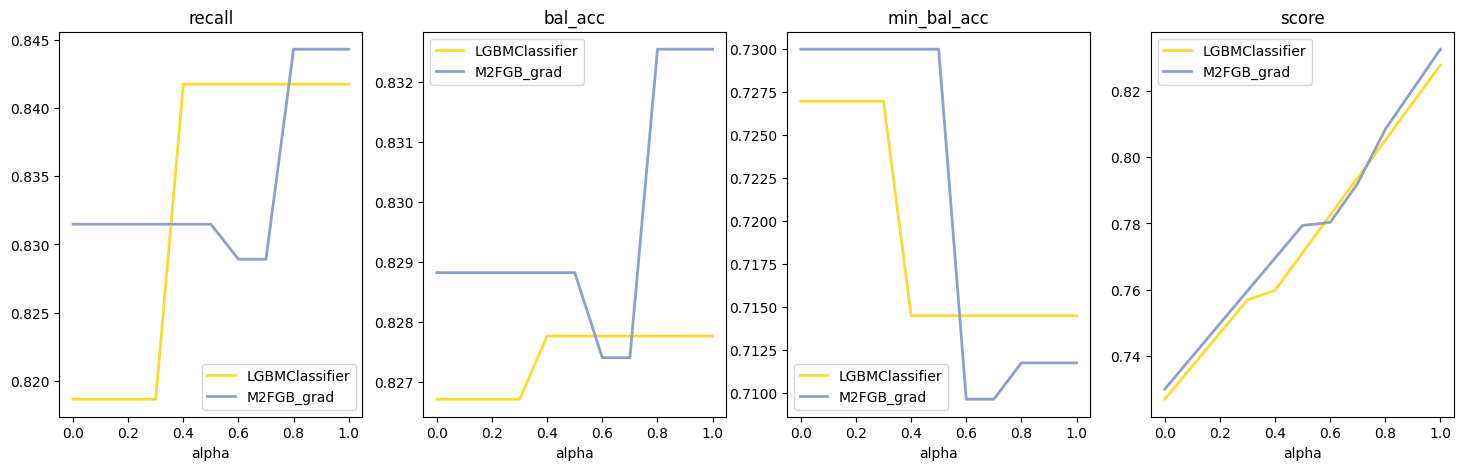

In [21]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_train"], results[model]["results_train"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")


df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")

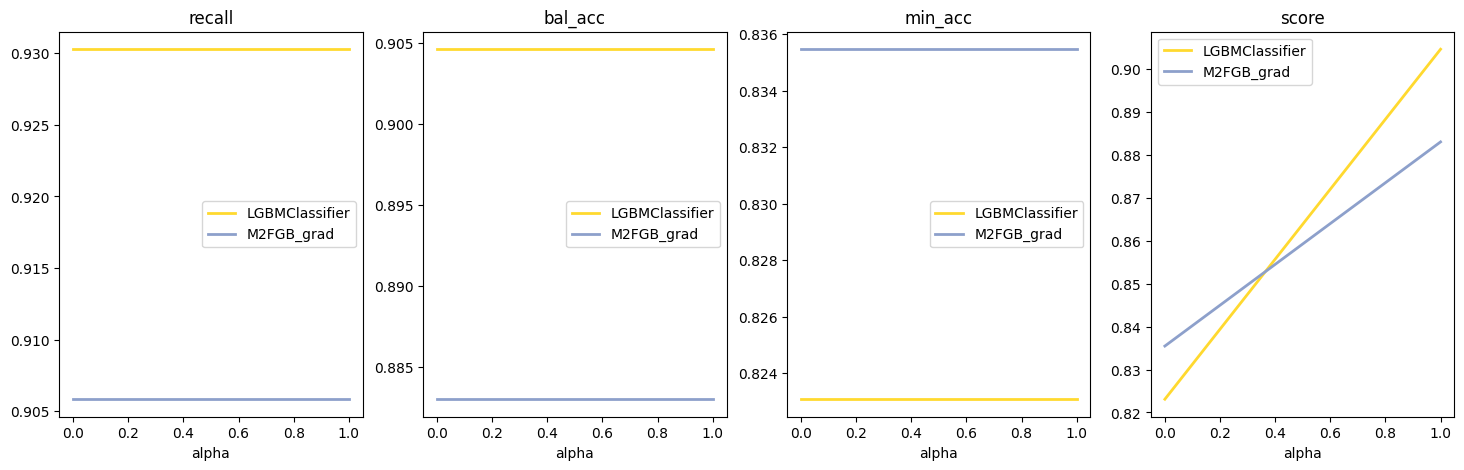

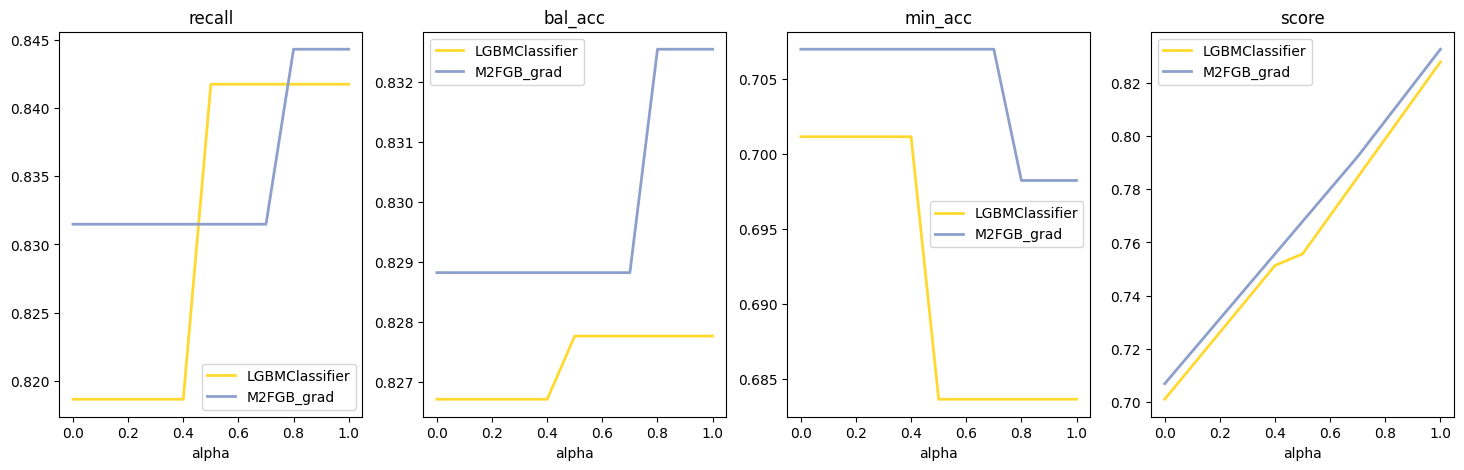

In [23]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_train"], results[model]["results_train"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")


df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")

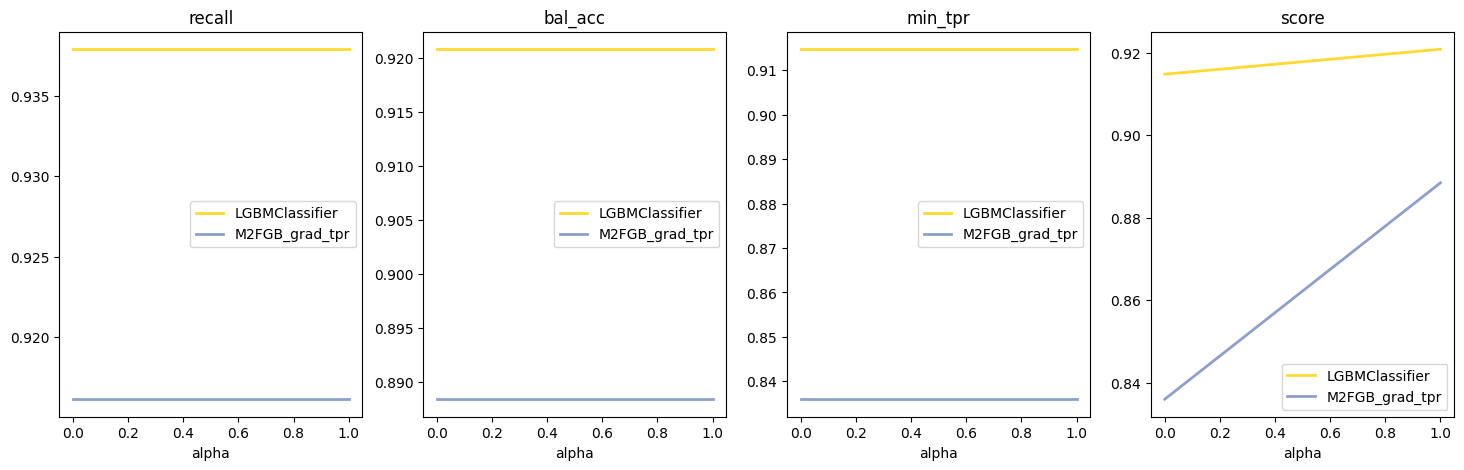

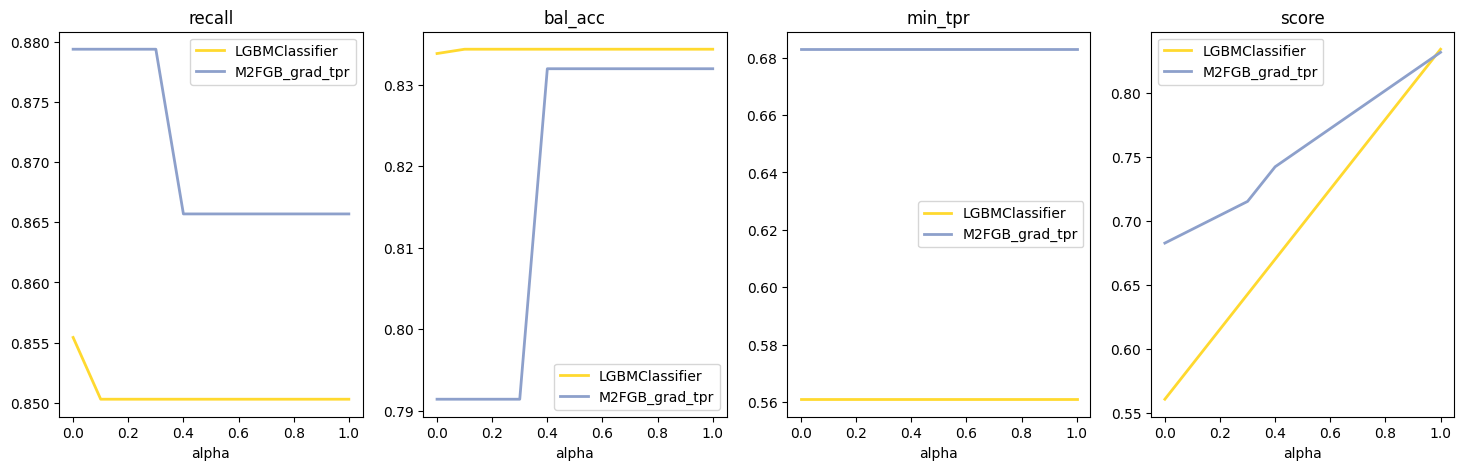

In [159]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha(model,results[model]["results_train"], results[model]["results_train"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")


df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")

### fairgbm procedure

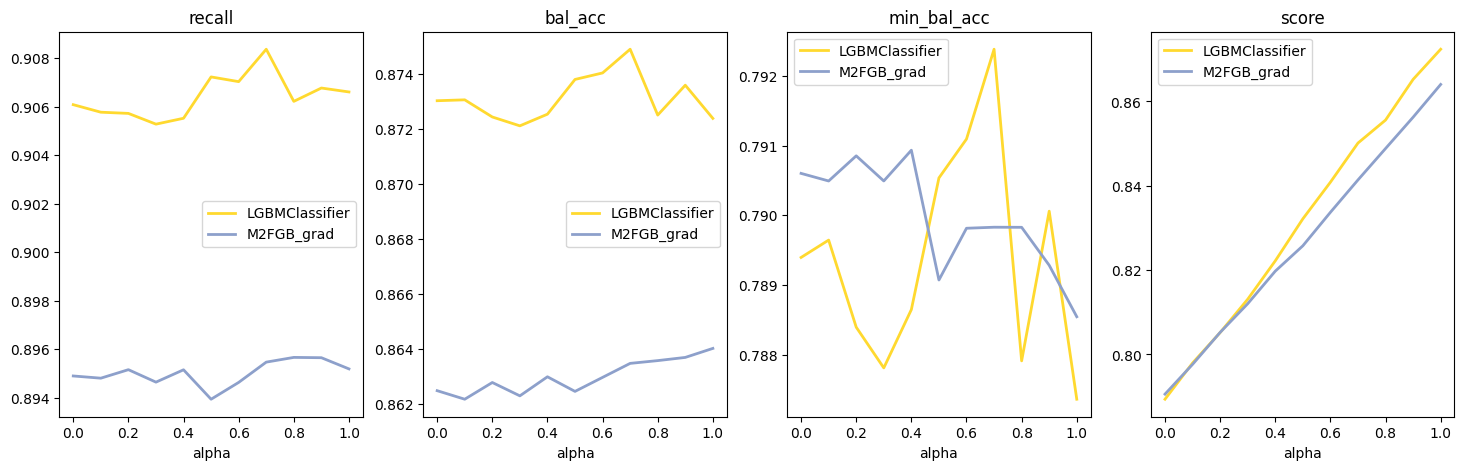

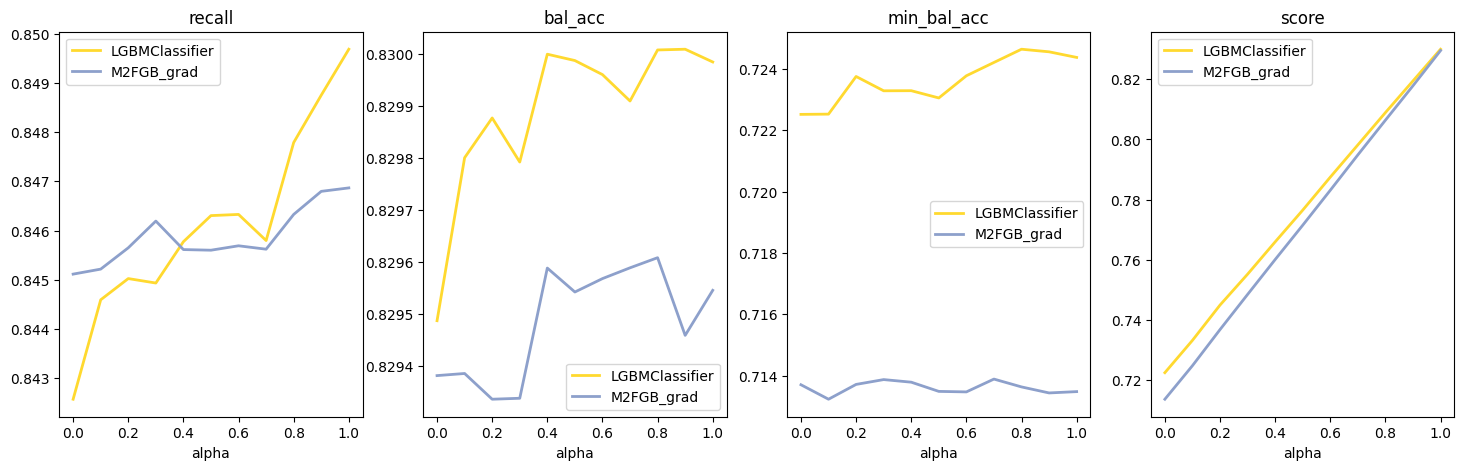

In [236]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_train"], results[model]["results_train"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")


df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_val"], results[model]["results_test"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")

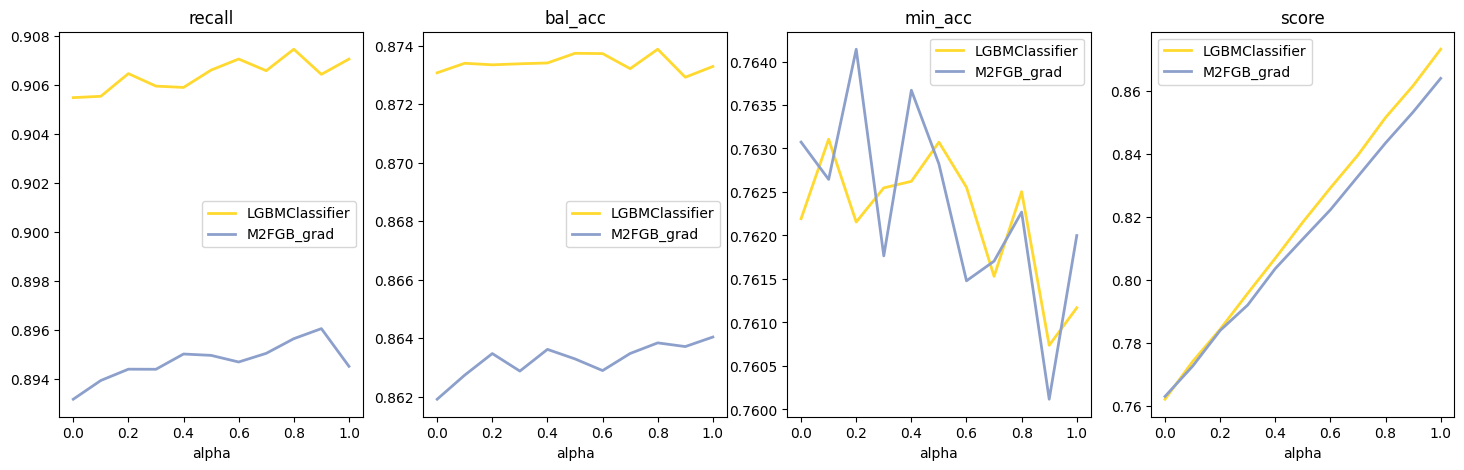

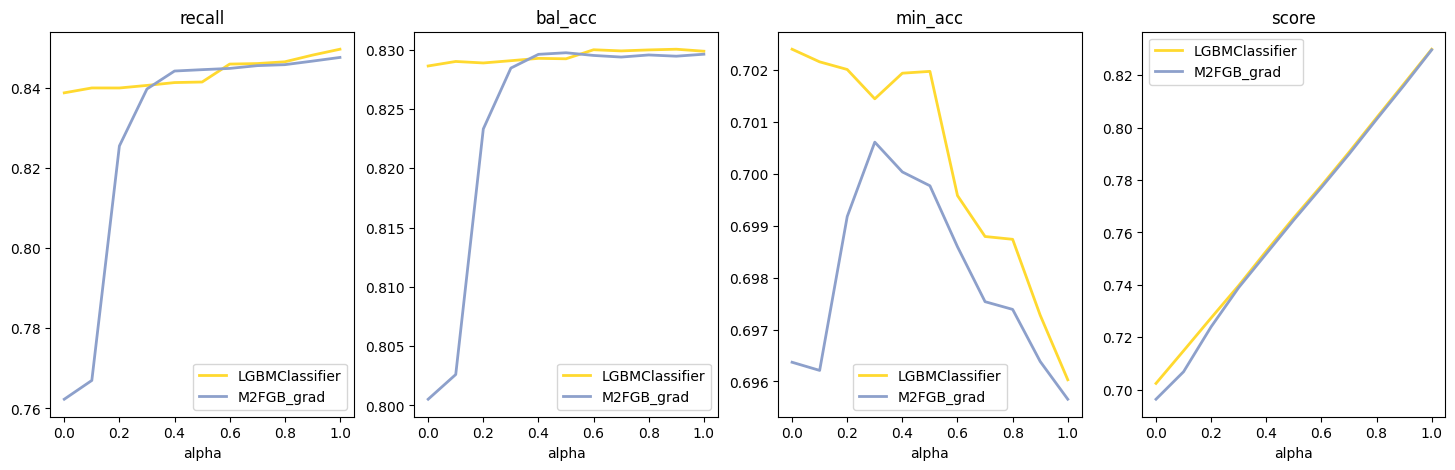

In [237]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_train"], results[model]["results_train"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")


df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_val"], results[model]["results_test"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")

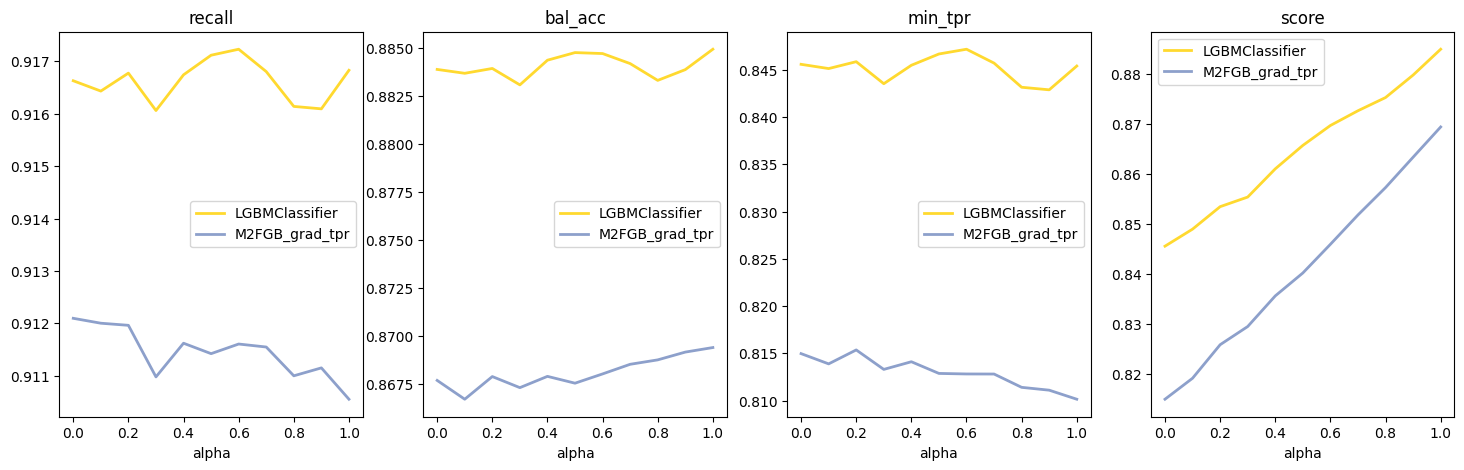

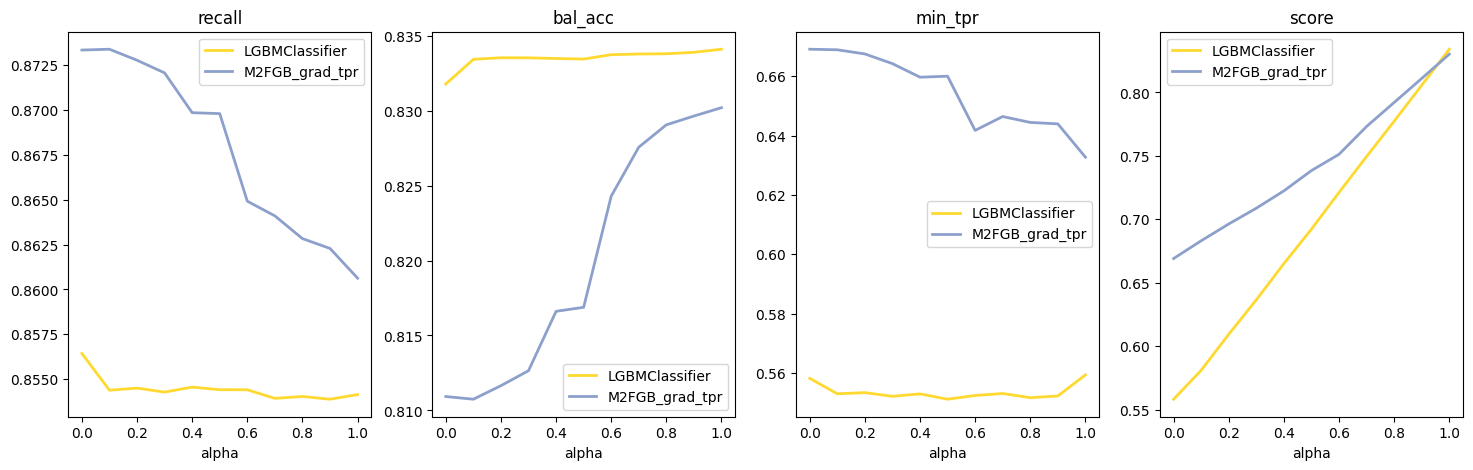

In [163]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_train"], results[model]["results_train"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")


df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_val"], results[model]["results_test"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")

## with really more trials

In [165]:
results = {}
for model in ["LGBMClassifier", "M2FGB_grad", "M2FGB_grad_tpr"]:
    results[model] = exp_v1(model, 750)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [11:41<00:00,  1.07it/s]


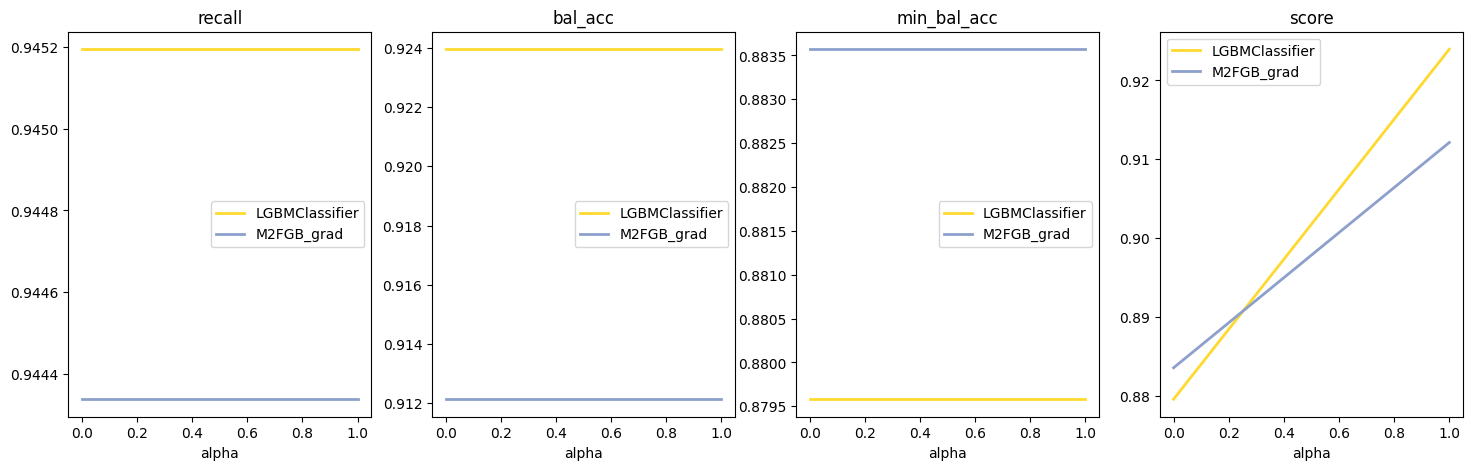

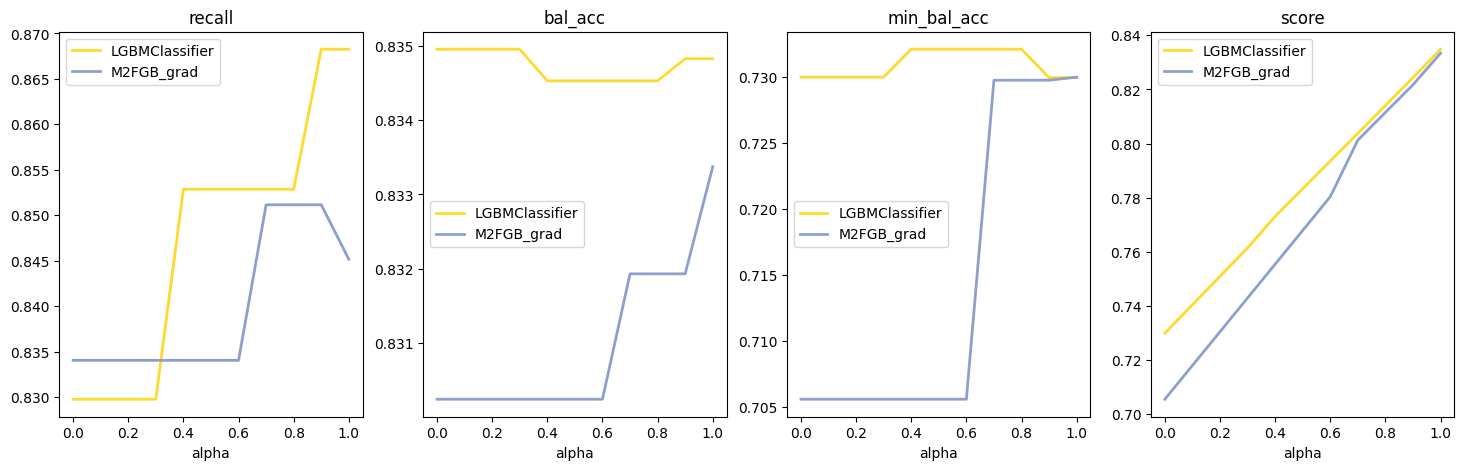

In [166]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_train"], results[model]["results_train"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")

df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")

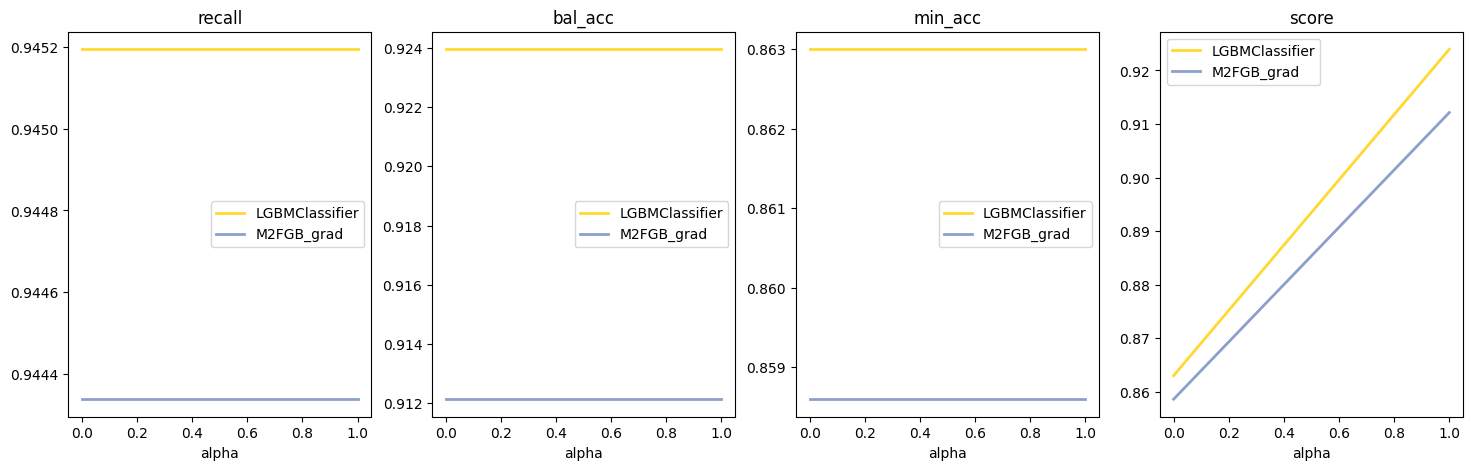

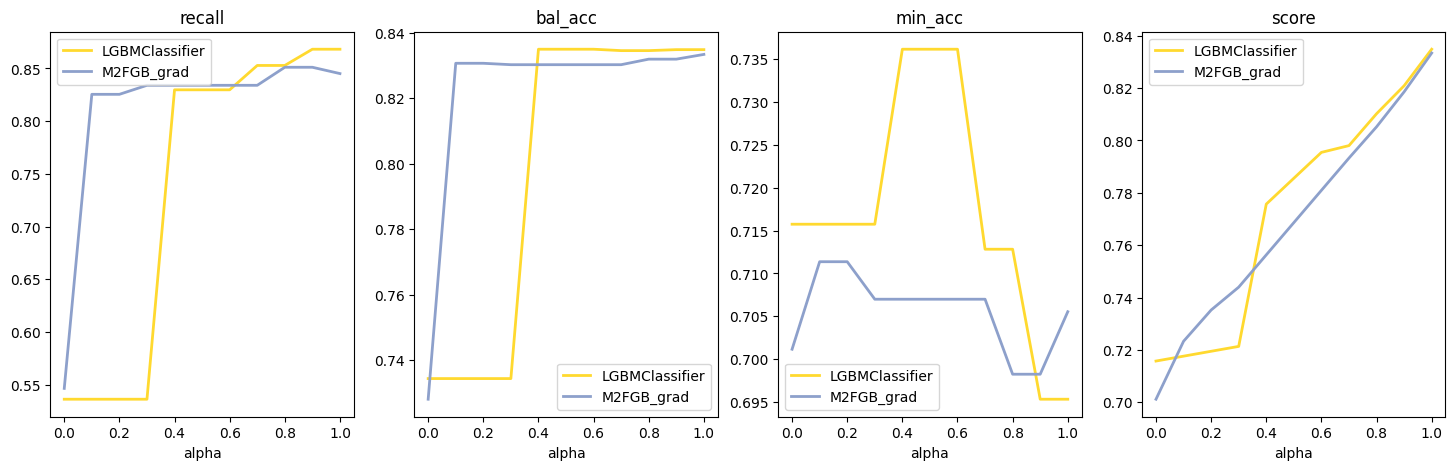

In [167]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_train"], results[model]["results_train"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")

df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")

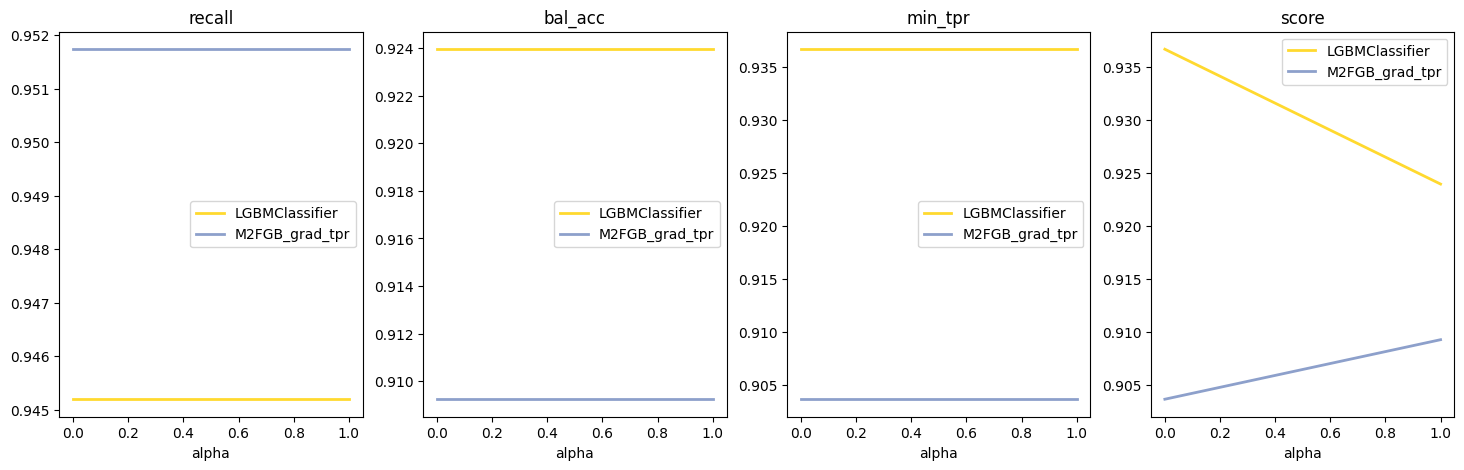

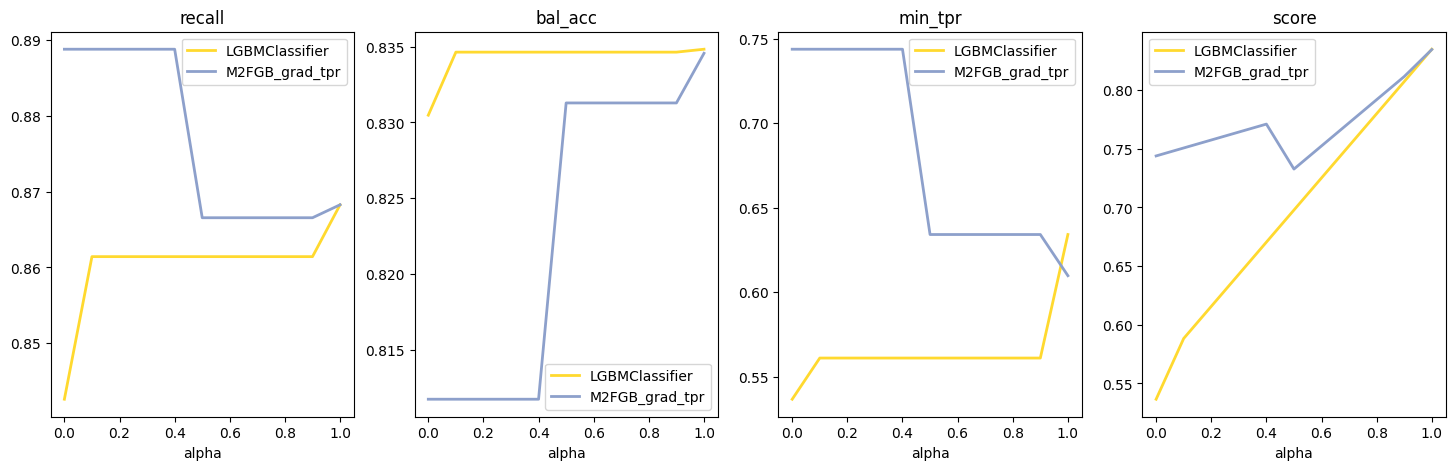

In [168]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha(model,results[model]["results_train"], results[model]["results_train"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")

df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")

### fairgbm procedure

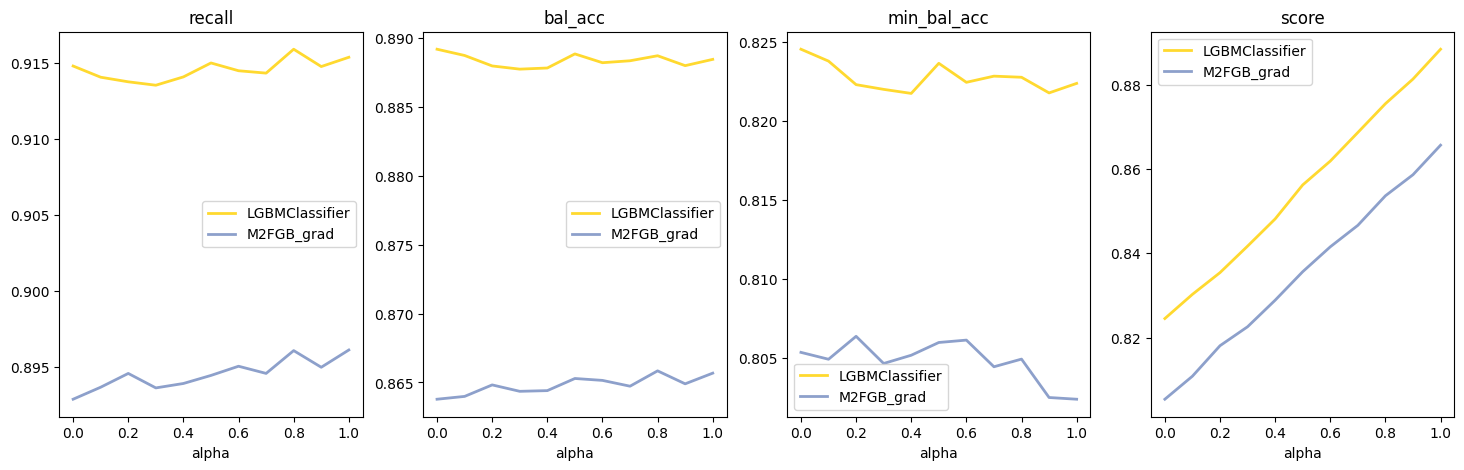

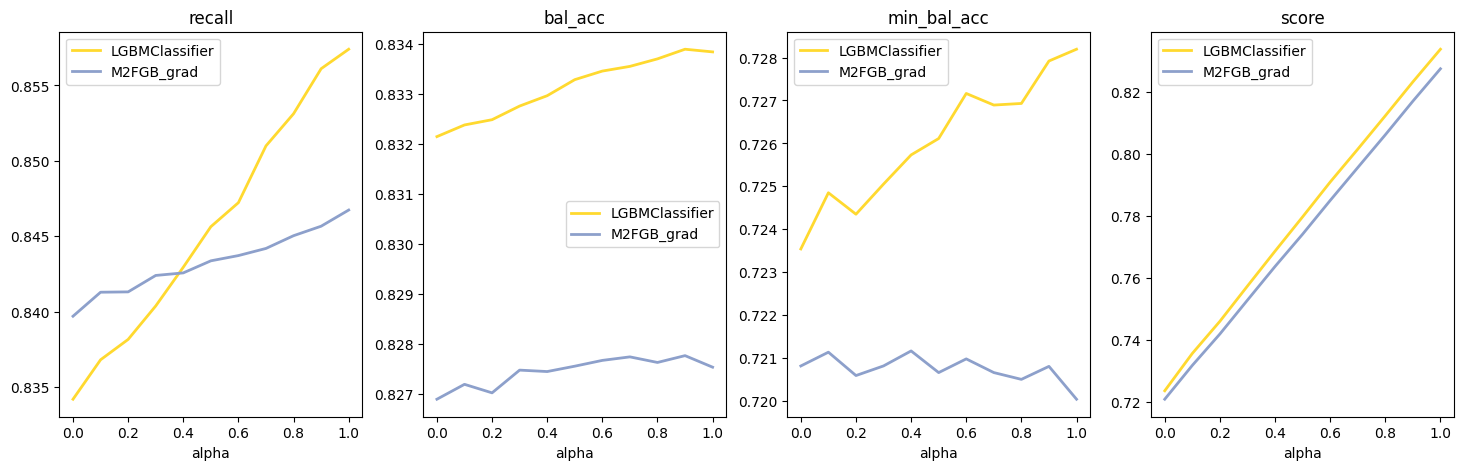

In [169]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_train"], results[model]["results_train"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")

df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_val"], results[model]["results_test"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")

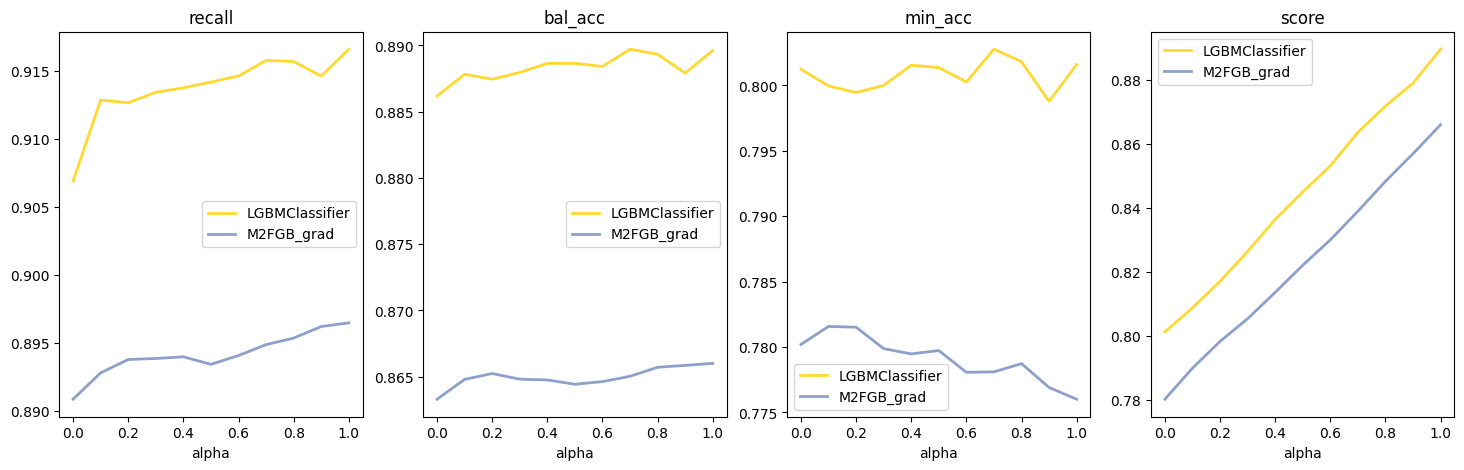

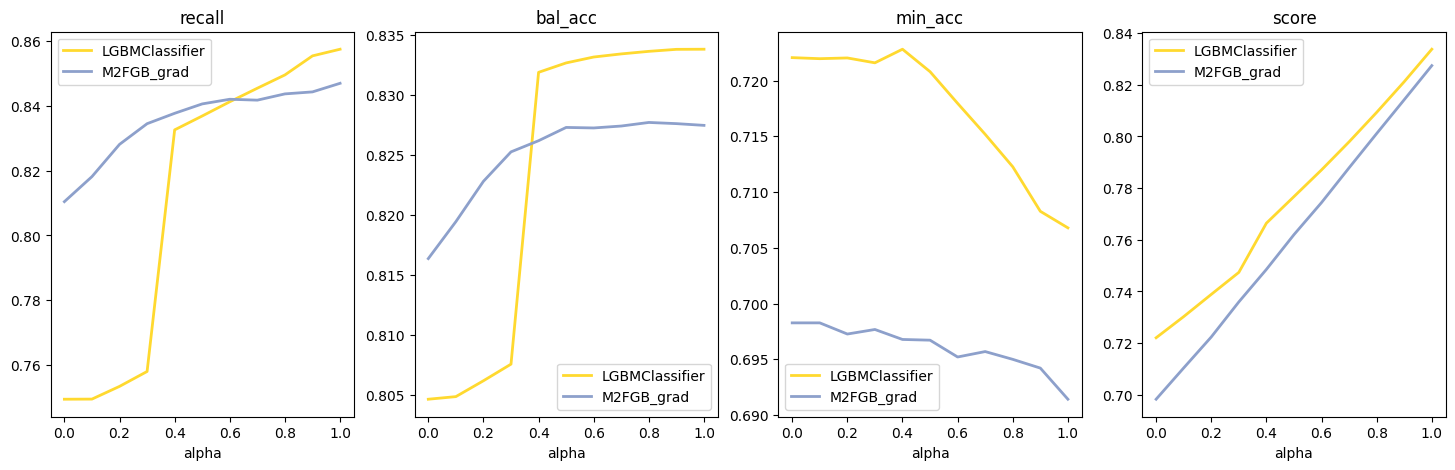

In [170]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_train"], results[model]["results_train"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")

df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_val"], results[model]["results_test"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")

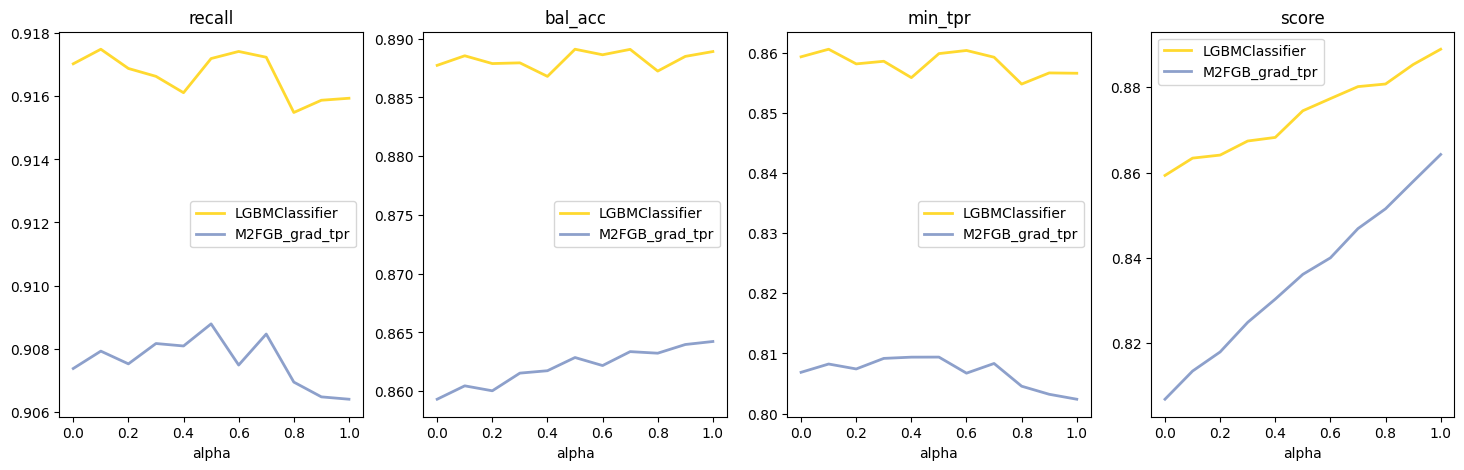

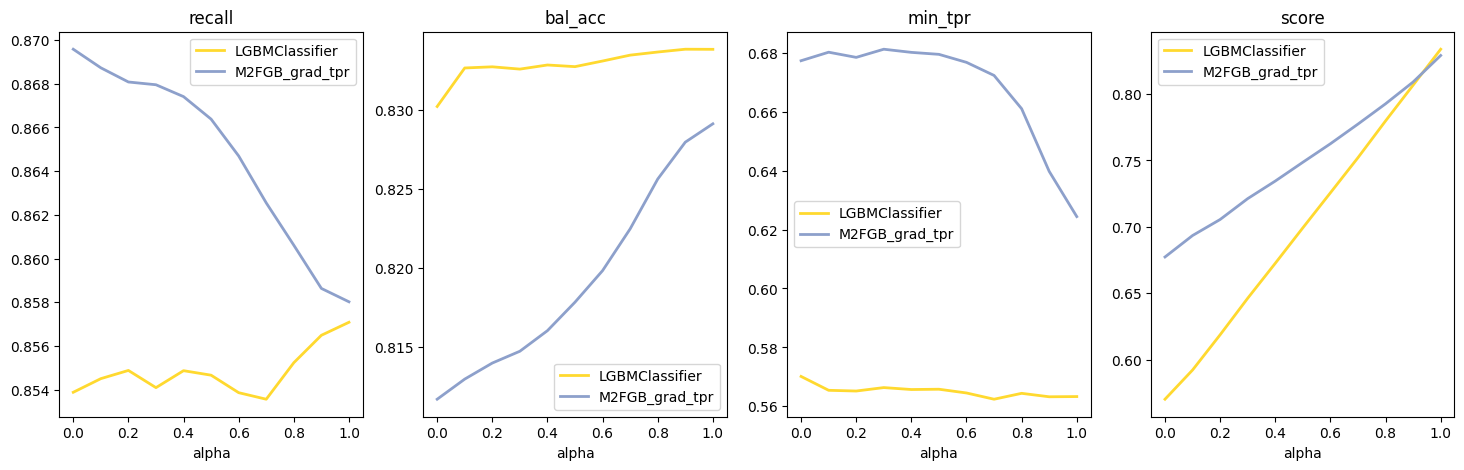

In [171]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_train"], results[model]["results_train"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")

df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_val"], results[model]["results_test"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")

## m2fgb but it is not fair

In [45]:
def exp_v3(model, n_trials = 100):
    model_list = []
    if model == "M2FGB_not_fair":
        param_space = experiments.get_param_spaces("M2FGB_grad")
        param_space["fair_weight"] = {"type": "float", "low": 0, "high": 0}
        del param_space["multiplier_learning_rate"]
    else:
        param_space = experiments.get_param_spaces(model)

    param_list = experiments.get_param_list(param_space, n_trials)
    if model == "M2FGB_not_fair":
        model_class = experiments.get_model("M2FGB_grad", random_state=seed)
    else:
        model_class = experiments.get_model(model, random_state=seed)
    
    threshold_list = []
    for params in tqdm(param_list):
        model_ = model_class(**params)
        model_.fit(X_train, Y_train, A_train)
        model_list.append(model_)
        # get the best threshold for each model
        y_score = model_.predict_proba(X_train)[:, 1]
        threshold_list.append(utils.get_best_threshold(Y_train, y_score))
    
    results_train = eval_model_list(
        model_list,
        X_train,
        Y_train,
        A_train,
        threshold_list
    )

    results_val = eval_model_list(
        model_list,
        X_val,
        Y_val,
        A_val,
        threshold_list
    )

    results_test = eval_model_list(
        model_list,
        X_test,
        Y_test,
        A_test,
        threshold_list
    )

    return {
        "model_list" : model_list,
        "results_train" : results_train,
        "results_val" : results_val,
        "results_test" : results_test
    }


In [199]:
results = {}
for model in ["LGBMClassifier", "M2FGB_not_fair"]:
    results[model] = exp_v3(model, 10)

  0%|                                                                                                                                                             | 0/10 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.74it/s]


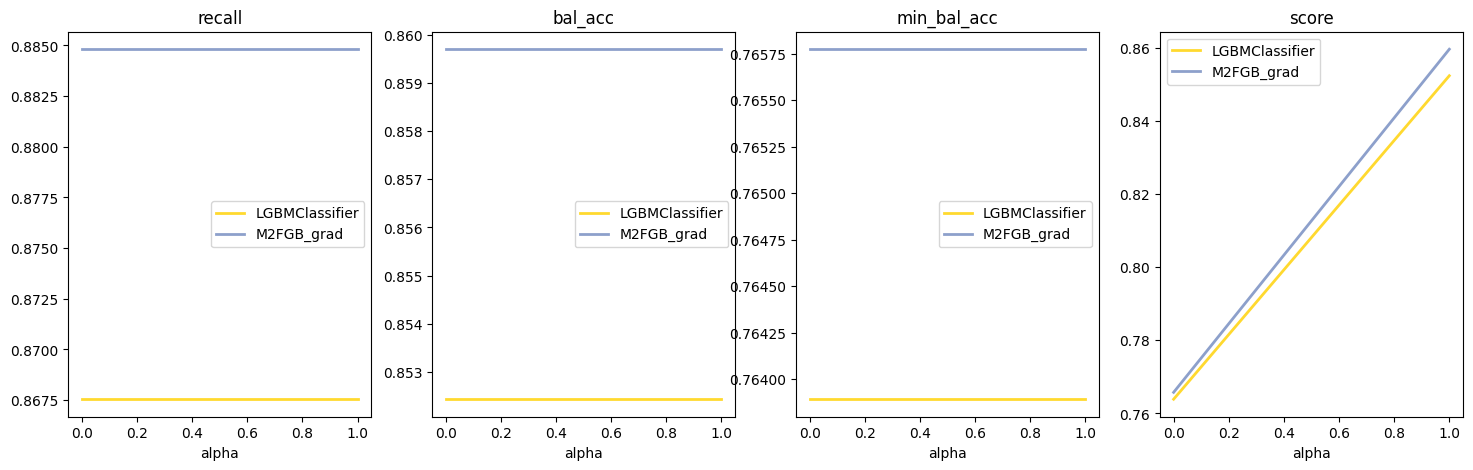

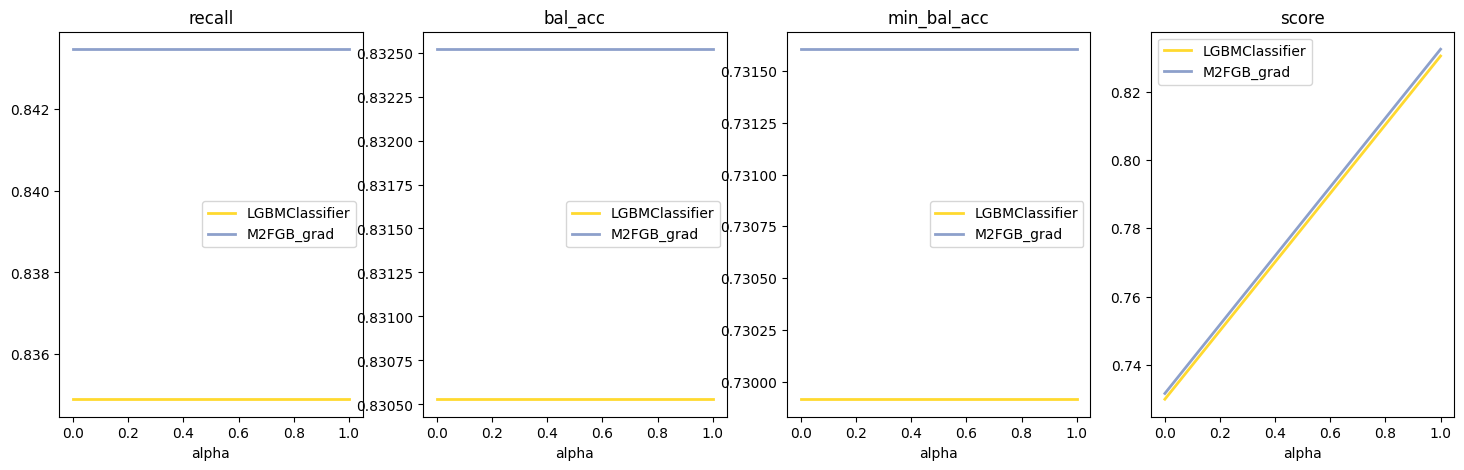

In [200]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_not_fair"]:
    df_results.append(select_model_alpha(model,results[model]["results_train"], results[model]["results_train"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")


df_results = []
for model in ["LGBMClassifier", "M2FGB_not_fair"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")

## alpha curve across folds

In [54]:
dataset = "compas"
seed = 0
n_folds = 10
df_results = []
for fold in range(n_folds):
    X_train, A_train, Y_train, X_val, A_val, Y_val, X_test, A_test, Y_test =  data.get_fold(dataset, fold, n_folds, 8, seed)

    for model in ["LGBMClassifier", "M2FGB_grad"]:
        results_dict = exp_v1(model, n_trials = 100)
        results_ = select_model_alpha(model, results_dict["results_val"], results_dict["results_test"], "min_acc")
        results_["fold"] = fold
        df_results.append(results_)

df_results = pd.concat(df_results)

{'4_False': 0, '1_True': 1, '4_True': 2, '2_True': 3, '2_False': 4, '1_False': 5, '3_True': 6, '3_False': 7}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.94it/s]


{'4_False': 0, '1_True': 1, '4_True': 2, '2_True': 3, '2_False': 4, '1_False': 5, '3_True': 6, '3_False': 7}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.35it/s]


{'4_False': 0, '1_True': 1, '4_True': 2, '2_True': 3, '2_False': 4, '1_False': 5, '3_True': 6, '3_False': 7}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.00it/s]


{'4_False': 0, '1_True': 1, '4_True': 2, '2_True': 3, '2_False': 4, '1_False': 5, '3_True': 6, '3_False': 7}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.55it/s]


{'4_False': 0, '1_True': 1, '4_True': 2, '2_True': 3, '2_False': 4, '1_False': 5, '3_True': 6, '3_False': 7}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.44it/s]


{'4_False': 0, '1_True': 1, '4_True': 2, '2_True': 3, '2_False': 4, '1_False': 5, '3_True': 6, '3_False': 7}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.86it/s]


{'4_False': 0, '1_True': 1, '4_True': 2, '2_True': 3, '2_False': 4, '1_False': 5, '3_True': 6, '3_False': 7}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.43it/s]


{'4_False': 0, '1_True': 1, '4_True': 2, '2_True': 3, '2_False': 4, '1_False': 5, '3_True': 6, '3_False': 7}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.64it/s]


{'4_False': 0, '1_True': 1, '4_True': 2, '2_True': 3, '2_False': 4, '1_False': 5, '3_True': 6, '3_False': 7}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.62it/s]


{'4_False': 0, '1_True': 1, '4_True': 2, '2_True': 3, '2_False': 4, '1_False': 5, '3_True': 6, '3_False': 7}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:04<00:00,  5.45s/it]


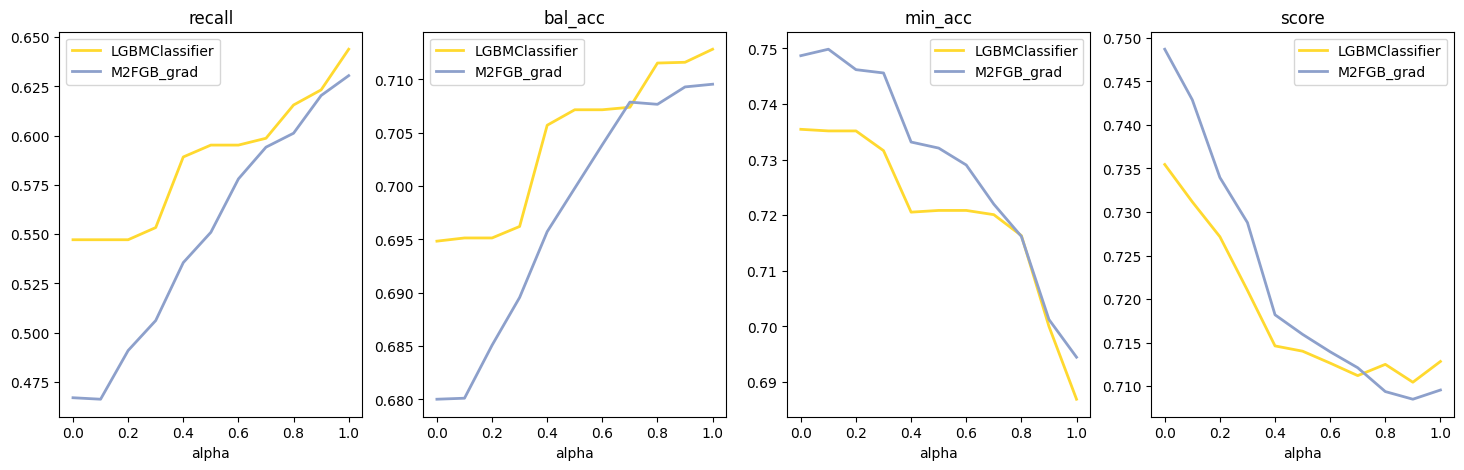

In [53]:
plot_perf_lines(df_results.groupby(["model", "alpha"]).mean().reset_index(), "min_acc")

## alpha curve but with lgbm is a version of m2fgb

In [50]:
dataset = "taiwan"
seed = 42
n_folds = 5
df_results = []
for fold in range(n_folds):
    X_train, A_train, Y_train, X_val, A_val, Y_val, X_test, A_test, Y_test =  data.get_fold(dataset, fold, n_folds, 8, seed)

    for model in ["LGBMClassifier", "M2FGB_grad"]:
        results_dict = exp_v3(model, n_trials = 100)
        results_ = select_model_alpha(model, results_dict["results_val"], results_dict["results_test"], "min_acc")
        results_["fold"] = fold
        df_results.append(results_)

df_results = pd.concat(df_results)

{'Female_1': 0, 'Female_2': 1, 'Male_4': 2, 'Male_2': 3, 'Male_1': 4, 'Female_4': 5, 'Female_3': 6, 'Male_3': 7}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.65it/s]


{'Female_1': 0, 'Female_2': 1, 'Male_4': 2, 'Male_2': 3, 'Male_1': 4, 'Female_4': 5, 'Female_3': 6, 'Male_3': 7}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.74it/s]


{'Female_1': 0, 'Female_2': 1, 'Male_4': 2, 'Male_2': 3, 'Male_1': 4, 'Female_4': 5, 'Female_3': 6, 'Male_3': 7}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


{'Female_1': 0, 'Female_2': 1, 'Male_4': 2, 'Male_2': 3, 'Male_1': 4, 'Female_4': 5, 'Female_3': 6, 'Male_3': 7}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.25it/s]


{'Female_1': 0, 'Female_2': 1, 'Male_4': 2, 'Male_2': 3, 'Male_1': 4, 'Female_4': 5, 'Female_3': 6, 'Male_3': 7}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


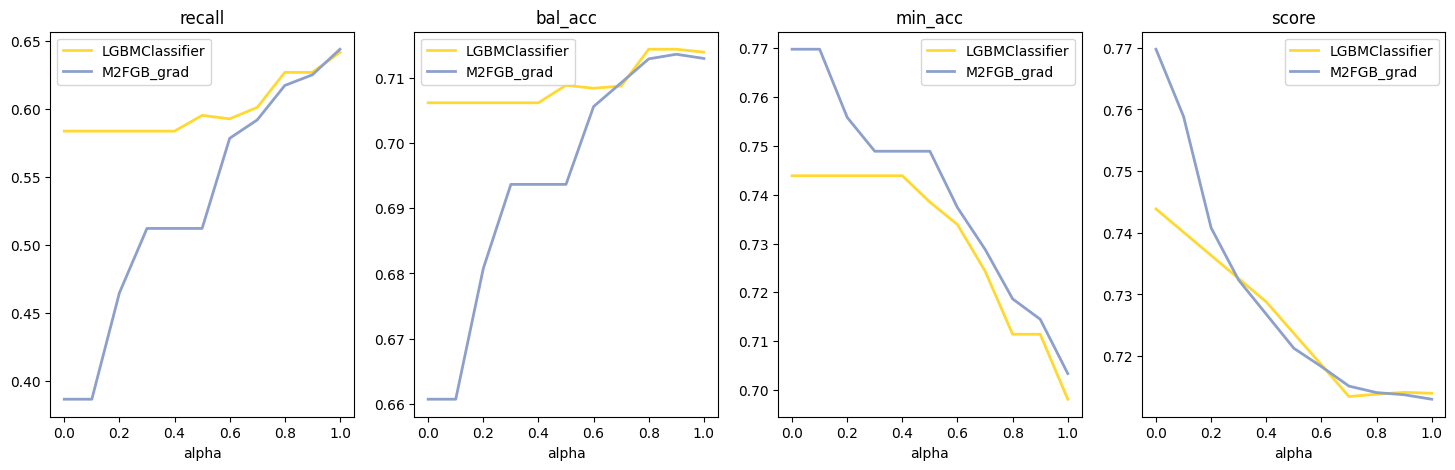

In [51]:
plot_perf_lines(df_results.groupby(["model", "alpha"]).mean().reset_index(), "min_acc")

## small param space

In [135]:
small_param_spaces = {}
small_param_spaces["LGBMClassifier"] = {
    #"min_child_weight": {"type": "float", "low": 0.001, "high": 10, "log": True},
    #"num_leaves": {"type": "int", "low": 2, "high": 1000, "log": True},
    "n_estimators": {"type": "int", "low": 200, "high": 1000, "log": True},
    #"min_child_samples": {"type": "int", "low": 5, "high": 500, "log": True},
    #"max_depth": {"type": "int", "low": 2, "high": 10},
    #"reg_lambda": {"type": "float", "low": 0.001, "high": 1000, "log": True},
    "learning_rate": {"type": "float", "low": 0.01, "high": 0.5, "log": True},
}

small_param_spaces["M2FGB_grad"] = small_param_spaces["LGBMClassifier"].copy()
small_param_spaces["M2FGB_grad"]["fair_weight"] = {"type": "float", "low": 1e-3, "high": 0.5, "log": True}
small_param_spaces["M2FGB_grad"]["multiplier_learning_rate"] = {"type": "float", "low": 0.01, "high": 0.5}

In [101]:
def exp_v4(model, n_trials = 100):
    model_list = []
    param_space = small_param_spaces[model]
    param_list = experiments.get_param_list(param_space, n_trials)
    model_class = experiments.get_model(model, random_state=seed)
    threshold_list = []
    for params in tqdm(param_list):
        model_ = model_class(**params)
        model_.fit(X_train, Y_train, A_train)
        model_list.append(model_)
        # get the best threshold for each model
        y_score = model_.predict_proba(X_train)[:, 1]
        threshold_list.append(utils.get_best_threshold(Y_train, y_score))
    
    results_train = eval_model_list(
        model_list,
        X_train,
        Y_train,
        A_train,
        threshold_list
    )

    results_val = eval_model_list(
        model_list,
        X_val,
        Y_val,
        A_val,
        threshold_list
    )

    results_test = eval_model_list(
        model_list,
        X_test,
        Y_test,
        A_test,
        threshold_list
    )

    return {
        "model_list" : model_list,
        "results_train" : results_train,
        "results_val" : results_val,
        "results_test" : results_test
    }


In [107]:
results = {}
for model in ["LGBMClassifier", "M2FGB_grad"]:#, "M2FGB_grad_tpr"]:
    results[model] = exp_v4(model, 50)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:58<00:00,  3.56s/it]


In [136]:
model = "M2FGB_grad"
results[model] = exp_v4(model, 50)

  0%|                                                                                                                   | 0/50 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:06<00:00,  3.73s/it]


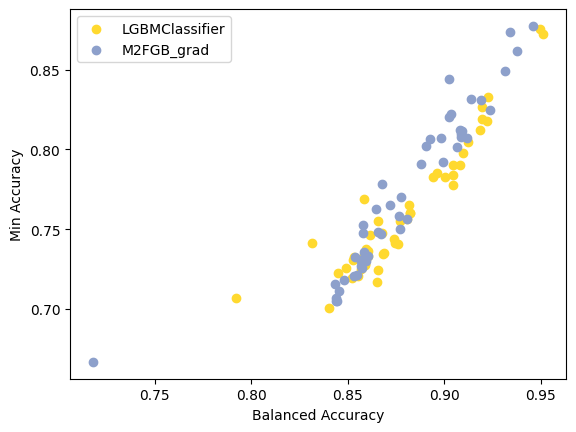

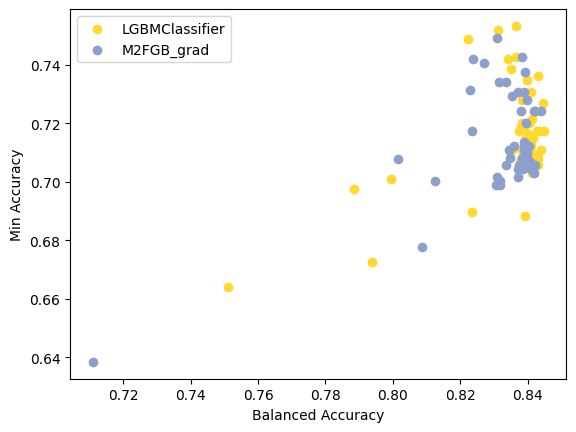

In [112]:
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_temp = results[model]["results_train"]

    plt.scatter(
        df_temp["bal_acc"],
        df_temp["min_acc"],
        label = model,
        color = methods_color[model]
    )

plt.xlabel("Balanced Accuracy")
plt.ylabel("Min Accuracy")
plt.legend()

plt.show()

for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_temp = results[model]["results_val"]

    plt.scatter(
        df_temp["bal_acc"],
        df_temp["min_acc"],
        label = model,
        color = methods_color[model]
    )

plt.xlabel("Balanced Accuracy")
plt.ylabel("Min Accuracy")
plt.legend()
plt.show()

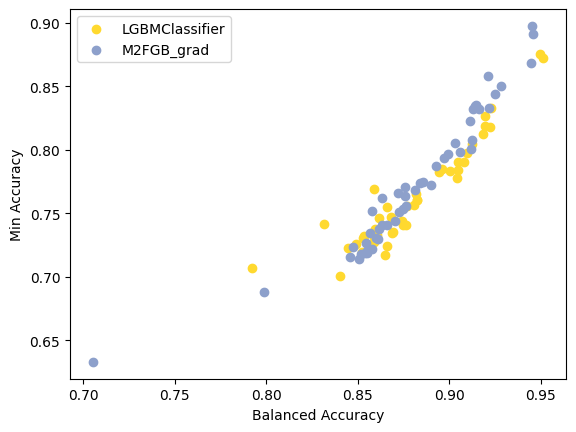

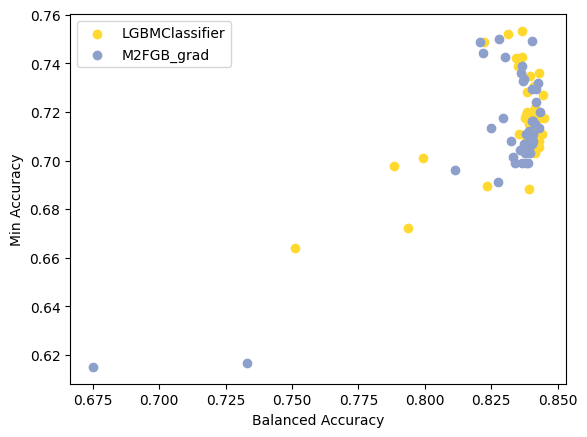

In [116]:
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_temp = results[model]["results_train"]

    plt.scatter(
        df_temp["bal_acc"],
        df_temp["min_acc"],
        label = model,
        color = methods_color[model]
    )

plt.xlabel("Balanced Accuracy")
plt.ylabel("Min Accuracy")
plt.legend()

plt.show()

for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_temp = results[model]["results_val"]

    plt.scatter(
        df_temp["bal_acc"],
        df_temp["min_acc"],
        label = model,
        color = methods_color[model]
    )

plt.xlabel("Balanced Accuracy")
plt.ylabel("Min Accuracy")
plt.legend()
plt.show()

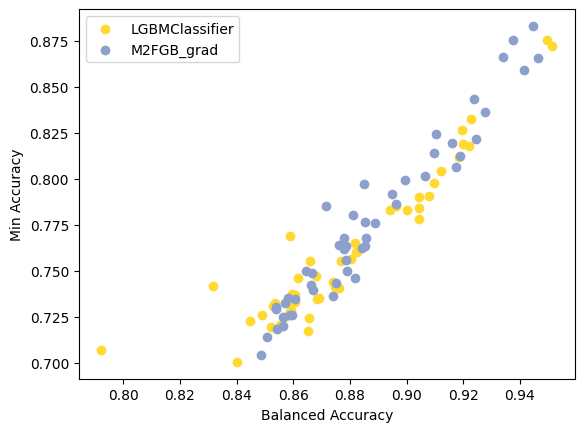

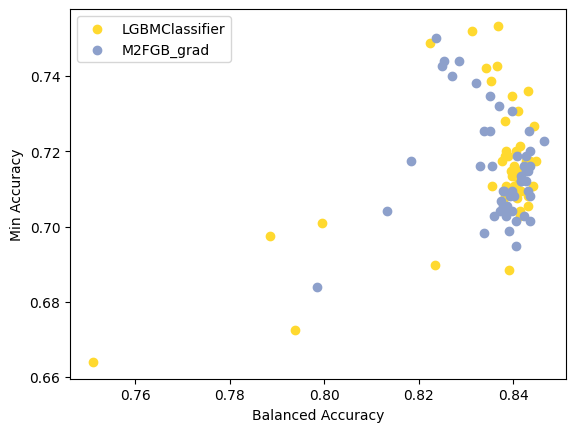

In [130]:
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_temp = results[model]["results_train"]

    plt.scatter(
        df_temp["bal_acc"],
        df_temp["min_acc"],
        label = model,
        color = methods_color[model]
    )

plt.xlabel("Balanced Accuracy")
plt.ylabel("Min Accuracy")
plt.legend()

plt.show()

for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_temp = results[model]["results_val"]

    plt.scatter(
        df_temp["bal_acc"],
        df_temp["min_acc"],
        label = model,
        color = methods_color[model]
    )

plt.xlabel("Balanced Accuracy")
plt.ylabel("Min Accuracy")
plt.legend()
plt.show()

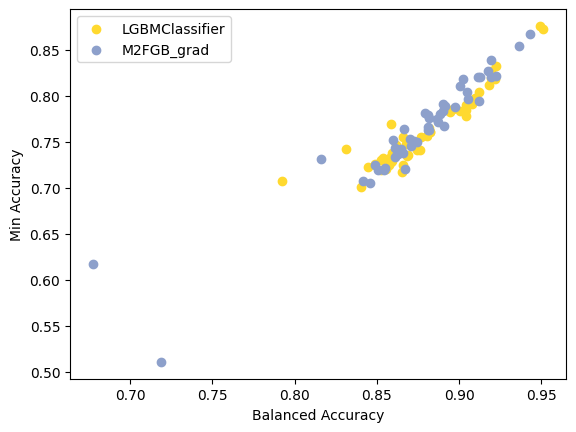

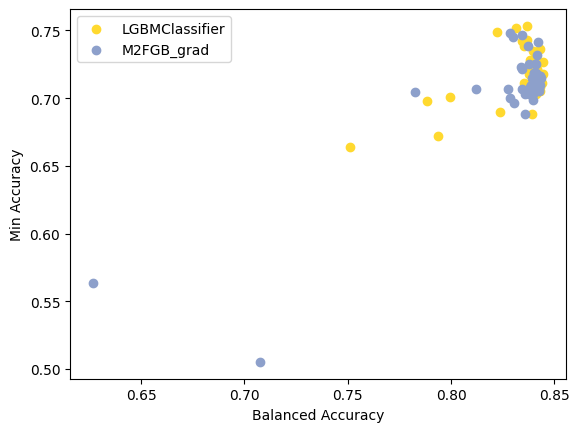

In [137]:
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_temp = results[model]["results_train"]

    plt.scatter(
        df_temp["bal_acc"],
        df_temp["min_acc"],
        label = model,
        color = methods_color[model]
    )

plt.xlabel("Balanced Accuracy")
plt.ylabel("Min Accuracy")
plt.legend()

plt.show()

for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_temp = results[model]["results_val"]

    plt.scatter(
        df_temp["bal_acc"],
        df_temp["min_acc"],
        label = model,
        color = methods_color[model]
    )

plt.xlabel("Balanced Accuracy")
plt.ylabel("Min Accuracy")
plt.legend()
plt.show()

[0.01602677] 0.7049687537931234


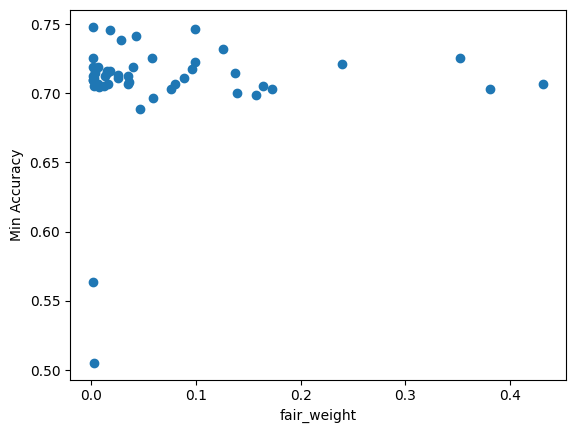

[-0.01638811] 0.7141347523896474


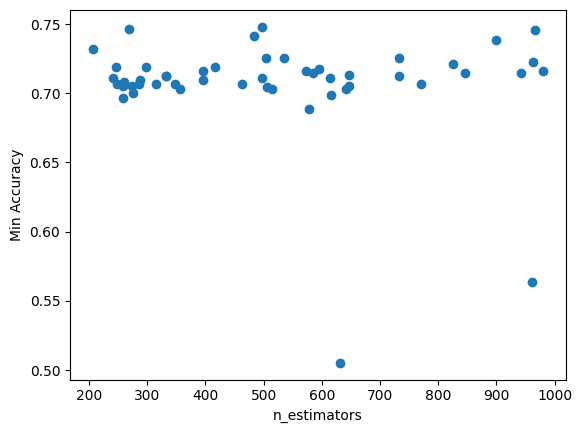

[-0.04533344] 0.7177497959651028


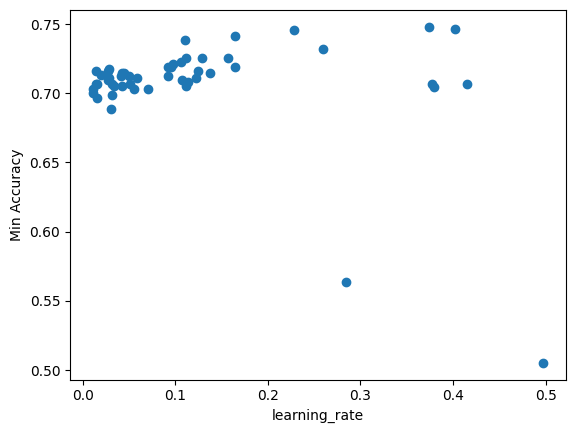

[-0.00660361] 0.7106473295305201


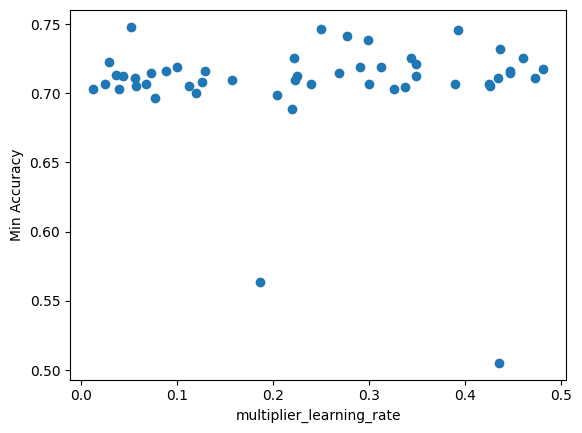

In [138]:
for p in ["fair_weight", "n_estimators", "learning_rate", "multiplier_learning_rate"]:
    params_ = [m.get_params()[p] for m in results["M2FGB_grad"]["model_list"]]
    #params_ = np.log(params_)
    plt.scatter(
        params_,
        results["M2FGB_grad"]["results_val"]["min_acc"]
    )
    plt.xlabel(p)
    plt.ylabel("Min Accuracy")

    # calculate a linear regression
    from sklearn.linear_model import LinearRegression
    params_ = np.array(params_, dtype = float)
    metric = results["M2FGB_grad"]["results_val"]["min_acc"].values

    # if p == "fair_weight":
    #     # get only values lower than 0.5
    #     mask = (params_ < 0.5) & (params_ > 0.1)
    #     params_ = params_[mask]
    #     metric = metric[mask]

    params_ -= params_.min()
    params_ /= params_.max()
    
    
    reg = LinearRegression().fit(params_.reshape(-1, 1), metric)
    print(reg.coef_, reg.intercept_)

    plt.show()

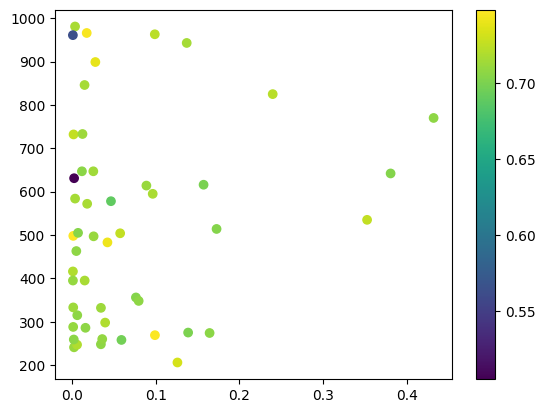

In [144]:
model_list = results["M2FGB_grad"]["model_list"]
fair_weight = [m.get_params()["fair_weight"] for m in model_list]
n_estimators = [m.get_params()["n_estimators"] for m in model_list]
learning_rate = [m.get_params()["learning_rate"] for m in model_list]
multiplier_learning_rate = [m.get_params()["multiplier_learning_rate"] for m in model_list]
min_acc = results["M2FGB_grad"]["results_val"]["min_acc"]


plt.scatter(
    fair_weight,
    n_estimators,
    c = min_acc,
)
plt.colorbar()